In [9]:
import py21cmfast as p21c
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15
import astropy.units as un
from py21cmfast.io.caching import RunCache, CacheConfig

from matplotlib import rcParams
rcParams.update({"font.size":20, "font.family": 'serif'})

In [10]:
F_STAR10 = -2.7619389378877255 # from Ivan
F_STAR7_MINI = -4.2 # adjusted to ensure continuity with ACGs at M_h = 10**8 M_sun
# TBD F_ESC10 = -1.35
# TBD F_ESC7_MINI = -1.35
ALPHA_STAR = 0.897330537277276630 # from Ivan
ALPHA_STAR_MINI = -0.3 # adjusted to ensure continuity with ACGs at M_h = 10**8 M_sun
# TBD ALPHA_ESC = -0.3
M_TURN = 5.0
t_STAR = 0.173760590479019067 #from Ivan
L_X = 40.5
NU_X_THRESH = 500
SIGMA_STAR = 0.14 # from Ivan
SIGMA_LX = 0.5
SIGMA_SFR_LIM = 0.19 # ~ from Ivan
SIGMA_SFR_INDEX = -0.12
R_BUBBLE_MAX = 50.0

In [11]:
def get_M_ast(f_ast, alpha_ast, M_h, M=10):
    if not hasattr(f_ast, "__len__"):
        f_ast = np.array([f_ast])
    if not hasattr(alpha_ast, "__len__"):
        alpha_ast = np.array([alpha_ast])
    M = 10**(M)#M_sun
    m_ast = np.zeros((alpha_ast.shape[0], M_h.shape[0]))
    for i in range(M_h.shape[0]):
        m_ast[:,i] = 10**f_ast * (10**M_h[i] / M)**alpha_ast * Planck15.Ob0/Planck15.Om0 * 10**M_h[i]
    return  np.log10(m_ast).squeeze()

def get_SFMS(M_ast, t_ast, z):
    if not hasattr(M_ast, "__len__"):
        M_ast = np.array([M_ast])
    if not hasattr(z, "__len__"):
        z = np.array([z])
    sfms = np.zeros(( z.shape[0],M_ast.shape[0]))
    for i in range(z.shape[0]):
        H = Planck15.H(z[i]).to(1/un.year).value
        sfms[i,:] = np.log10((10**M_ast) / (t_ast / H))
    return sfms

def get_Santini17_SFMS(M_ast, z, M=9.7):
    if z >= 4 and z <= 5:
        slope = 0.94 
        intercept = 1.37
    elif z >= 5 and z <= 6:
        slope = 0.92
        intercept = 1.99
    else:
        raise ValueError("Santini+17 goes up to z = 6")
    if not hasattr(M_ast, "__len__"):
        M_ast = np.array([M_ast])
    M = 10**M
    M_ast[M_ast < 10**8] = np.nan
    return slope*np.log10(M_ast/M) + intercept

def get_Rinaldi22_SFMS(M_ast, z):
    if z >= 4 and z <= 5:
        slope = 0.6 
        intercept = -4.93
    elif z >= 5 and z <= 6.5:
        slope = 0.59
        intercept = -4.79
    else:
        raise ValueError("Rinaldi+22 goes up to z = 6.5")
    if not hasattr(M_ast, "__len__"):
        M_ast = np.array([M_ast])
    M_ast[M_ast < 10**6] = np.nan
    return slope*np.log10(M_ast) + intercept

# SHMR

In [12]:
from matplotlib import rcParams
rcParams.update({"font.size":20, "font.family": 'serif'})

In [13]:
M_h_ACG = np.log10(np.logspace(8,10,1000))
SHMR_ACG = get_M_ast(F_STAR10, ALPHA_STAR, M_h_ACG)

M_h_MCG = np.log10(np.logspace(5,8,1000))
SHMR_MCG = get_M_ast(F_STAR7_MINI, ALPHA_STAR_MINI, M_h_MCG, M=7)

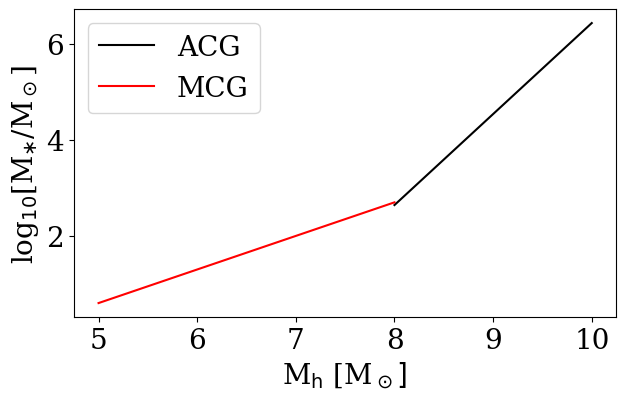

In [50]:
fig, ax = plt.subplots(1,1,figsize = (7,4))
ax.plot(M_h_ACG, SHMR_ACG, label = "ACG", color = "k")
ax.plot(M_h_MCG, SHMR_MCG, label = "MCG", color = "r")
ax.set_xlabel(r'M$_{\rm h}$ [M$_\odot]$')
ax.set_ylabel(r'log$_{10}$[M$_{\ast}$/M$_\odot$]')
plt.legend()
plt.show()

# SFMS

In [26]:
import matplotlib

In [27]:
redshifts = np.logspace(np.log10(5), np.log10(35), 10)
M_STAR = np.log10(np.logspace(5, 12, 100))

SFMS = get_SFMS(M_STAR, t_STAR, redshifts)

In [28]:
n_lines = SFMS.shape[0]
cmap = matplotlib.colormaps['plasma']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))

In [29]:
Santini_z5 = get_Santini17_SFMS(10**M_STAR, 5)
Santini_z6 = get_Santini17_SFMS(10**M_STAR, 6)

Rinaldi_z5 = get_Rinaldi22_SFMS(10**M_STAR, 5)
Rinaldi_z6 = get_Rinaldi22_SFMS(10**M_STAR, 6)

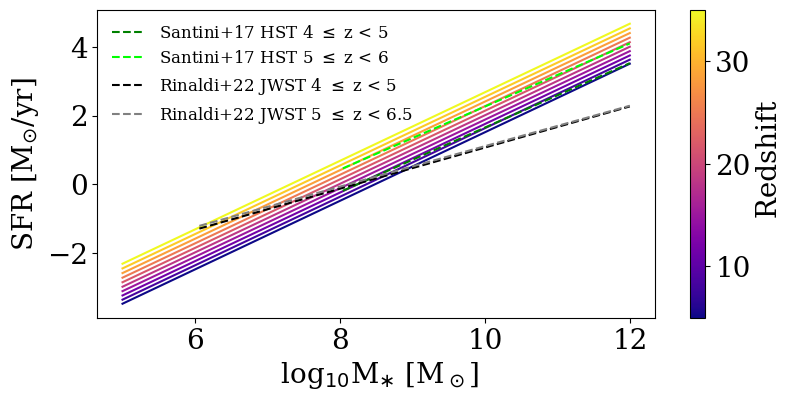

In [45]:
fig, ax = plt.subplots(1,1,figsize = (9,4))
cmap = matplotlib.colormaps["plasma"]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=redshifts[0], vmax=redshifts[-1]))
for i in range(SFMS.shape[0]):
    ax.plot(M_STAR, SFMS[i,:], color = colors[i])
plt.plot(M_STAR, Santini_z5, label = r"Santini+17 HST 4 $\leq$ z < 5", ls = "--", color = "g")
plt.plot(M_STAR, Santini_z6, label = r"Santini+17 HST 5 $\leq$ z < 6", ls = "--", color = "lime")

plt.plot(M_STAR, Rinaldi_z5, label = r"Rinaldi+22 JWST 4 $\leq$ z < 5", ls = "--", color = "k")
plt.plot(M_STAR, Rinaldi_z6, label = r"Rinaldi+22 JWST 5 $\leq$ z < 6.5", ls = "--", color = "grey")
ax.set_xlabel(r" log$_{10}$M$_{\ast}$ [M$_\odot$]")
ax.set_ylabel(r'SFR [M$_{\odot}$/yr]')
plt.colorbar(sm, ax=ax, label = r" Redshift")
plt.legend(fontsize = 12, frameon=False)
plt.show()

# UV LF

In [33]:
def get_halo_catalog_from_PHF(redshift, runcache, match_z_within=0.01):
    """
    """
    phf = runcache.get_output_struct_at_z(
            kind="PerturbHaloField",
            z=redshift,
            match_z_within=match_z_within,
    )
    
    return p21c.wrapper.cfuncs.convert_halo_properties(redshift=redshift, 
                                                       inputs=runcache.inputs, 
                                                       halo_masses=phf.halo_masses.loaded_from_disk().value, 
                                                       star_rng=phf.star_rng.loaded_from_disk().value, 
                                                       sfr_rng=phf.sfr_rng.loaded_from_disk().value, 
                                                       xray_rng=phf.xray_rng.loaded_from_disk().value, 
                                                       halo_coords=phf.halo_coords.loaded_from_disk().value)

def SFR2Luv(SFR):
    """from Ivan
    """
    interpolation_table = np.array(
      [2.48994108e+28, 2.48993878e+28, 2.48993574e+28, 2.48993173e+28,
       2.48992642e+28, 2.48991941e+28, 2.48991016e+28, 2.48989794e+28,
       2.48988181e+28, 2.48986052e+28, 2.48983243e+28, 2.48979538e+28,
       2.48974652e+28, 2.48968212e+28, 2.48959725e+28, 2.48948545e+28,
       2.48933823e+28, 2.48914446e+28, 2.48888951e+28, 2.48855423e+28,
       2.48811354e+28, 2.48753459e+28, 2.48677441e+28, 2.48577680e+28,
       2.48446829e+28, 2.48275278e+28, 2.48050459e+28, 2.47755920e+28,
       2.47370103e+28, 2.46864745e+28, 2.46202802e+28, 2.45335850e+28,
       2.44201055e+28, 2.42718128e+28, 2.40787267e+28, 2.38289890e+28,
       2.35094908e+28, 2.31074032e+28, 2.26129614e+28, 2.20236475e+28,
       2.13493071e+28, 2.06165620e+28, 1.98693929e+28, 1.91622469e+28,
       1.85447398e+28, 1.80440062e+28, 1.76569732e+28, 1.73551499e+28,
       1.68219535e+28, 1.64074902e+28])
    SFR_table = np.logspace(-4,2)
    k_uv = 1./np.interp(SFR, SFR_table, interpolation_table)
    return SFR / k_uv

def Luv2Muv(Luv):
    """
        Luv to Muv
    """
    return 51.63 - 2.5 * np.log10(Luv)

def get_uvlf(redshift, halo_catalog, inputs, bins=100, Luv_over_SFR=1.0 / 1.15 / 1e-28, components="both"):
    """
    halo_catalog has keys ['halo_mass', 'halo_stars', 'halo_sfr [Msun/s]', 'halo_xray', 
                           'n_ion', 'halo_wsfr', 'halo_stars_mini', 'halo_sfr_mini', 
                           'mturn_a', 'mturn_m', 'mturn_r', 'metallicity']
                           
    Luv_over_SFR default 1.0 / 1.15 / 1e-28 [M_solar yr^{-1} / (erg s^-1 Hz^-1)], G. Sun and S. R. Furlanetto (2016) MNRAS, 417, 33)
    """
    seconds_per_year = un.yr.to(un.s)

    if "halo_sfr_mini" in halo_catalog.keys() and components == "both":
        sfrs = halo_catalog["halo_sfr"] + halo_catalog["halo_sfr_mini"]
    else:
        sfrs = halo_catalog["halo_sfr"]
    sfrs = sfrs * seconds_per_year
    print("Max SFR:", np.max(sfrs), " and corresponding M_UV:", Luv2Muv([np.max(sfrs)]*Luv_over_SFR([np.max(sfrs)])))
    if callable(Luv_over_SFR):
        Luv_over_SFR = Luv_over_SFR(sfrs)
    Muv_cat = Luv2Muv(sfrs*Luv_over_SFR)

    hist, bin_edges = np.histogram(Muv_cat, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = np.diff(bin_edges)[0]

    # Normalize the histogram 1. by the survey volume, 2. bin width (for /mag/Mpc^3)
    sim_volume = inputs.simulation_options.BOX_LEN**3
    hist = hist / (bin_width * sim_volume)
    
    return {"M_uv":bin_centers, "lfunc":hist}

In [34]:
cache = p21c.OutputCache('/home/dbreitman/EOS25/TEST_F_ESC_-0pt1_ALPHA_ESC_0pt1_L384_HIIDIM256_DIM768')

inputs = p21c.InputParameters.from_template("/home/dbreitman/EOS25/EOS25/EOS25_astro.toml", 
                                            random_seed=1234,
                                           node_redshifts=p21c.wrapper.inputs.get_logspaced_redshifts(
        min_redshift=5.0,
        z_step_factor=1.02,
        max_redshift=35.0,
    ),).evolve_input_structs(F_ESC10 = -0.1, F_ESC7_MINI = -0.1, ALPHA_ESC=0.1,BOX_LEN=384, HII_DIM=256, DIM=768, SAMPLER_MIN_MASS=10**(9.71), N_THREADS=1)
runcache = RunCache.from_inputs(inputs, cache=cache)
initial_conditions = runcache.get_ics()

In [35]:
uvlf_redshifts = [6.,7.,8.,9.,10., 11., 12.5, 14.5]
uvlfs = {}
for redshift in uvlf_redshifts:
    halo_catalog = get_halo_catalog_from_PHF(redshift, runcache, match_z_within=0.1)
    uvlfs[str(redshift)] = get_uvlf(redshift, halo_catalog, inputs, bins=100, Luv_over_SFR=SFR2Luv)

Max SFR: 45.840694  and corresponding M_UV: [-27.28966119]
Max SFR: 42.328487  and corresponding M_UV: [-27.12178709]
Max SFR: 35.41654  and corresponding M_UV: [-26.75012384]
Max SFR: 21.058039  and corresponding M_UV: [-25.67771605]
Max SFR: 22.695353  and corresponding M_UV: [-25.83058246]
Max SFR: 18.998108  and corresponding M_UV: [-25.46629544]
Max SFR: 3.056189  and corresponding M_UV: [-21.71289003]
Max SFR: 1.4686139  and corresponding M_UV: [-20.15833069]


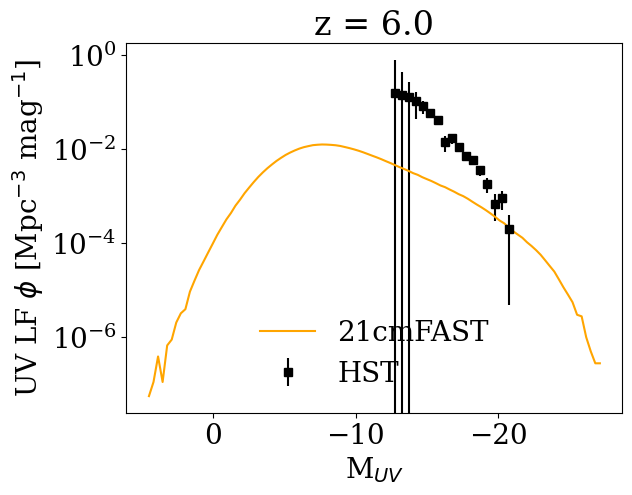

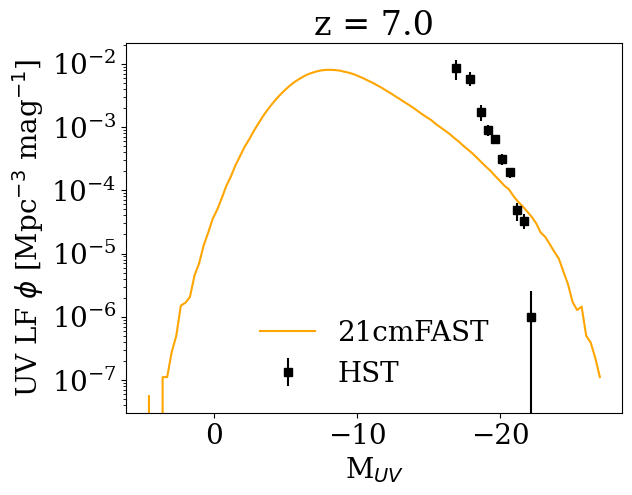

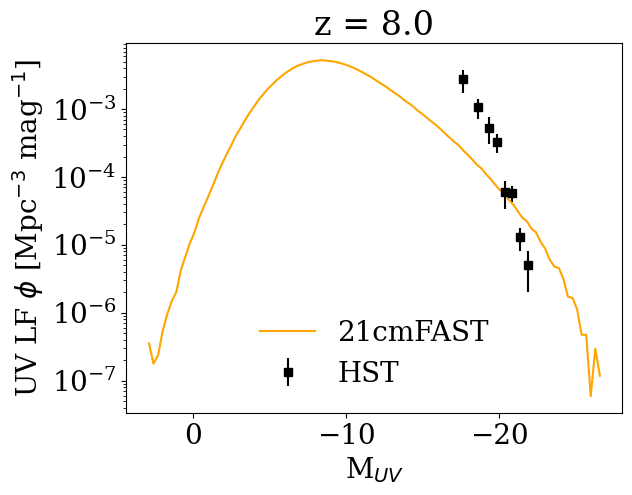

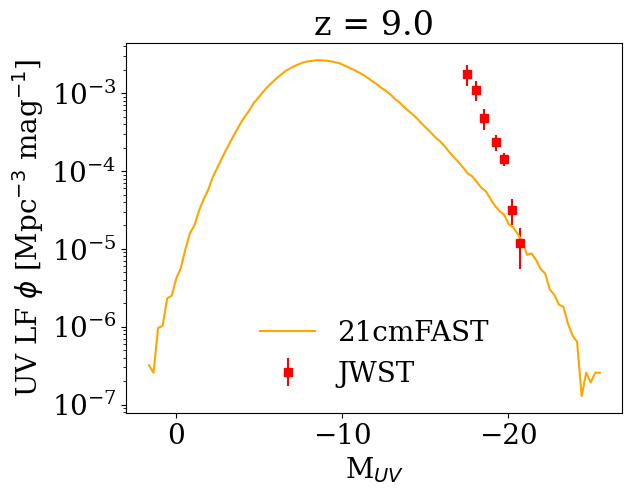

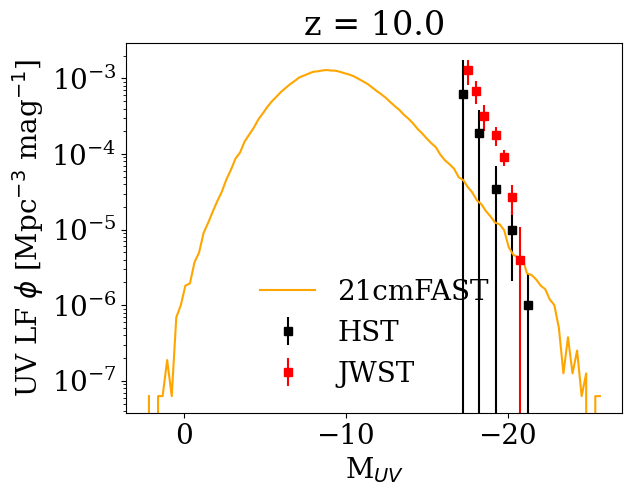

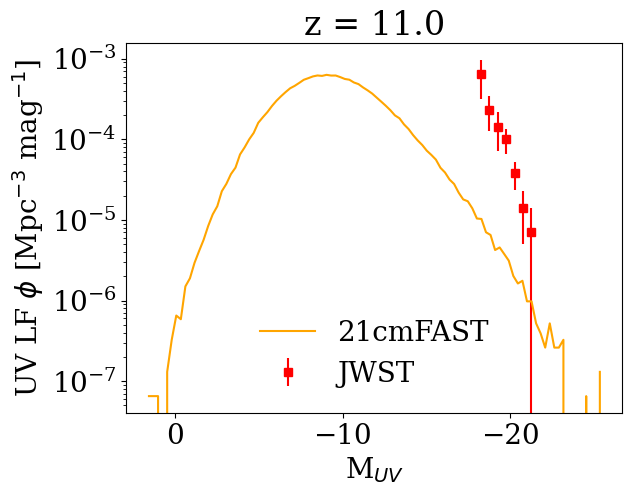

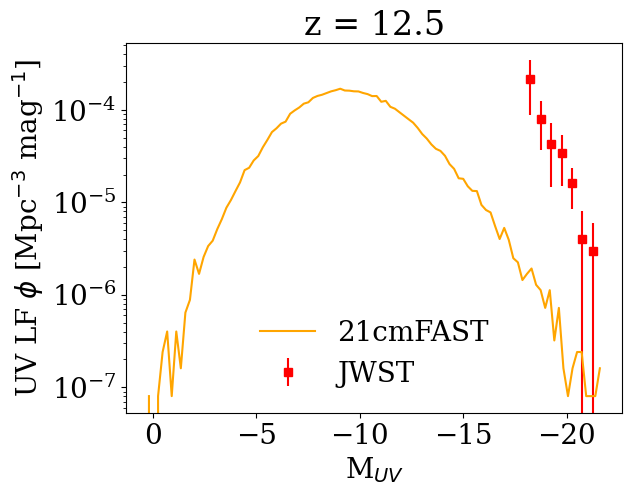

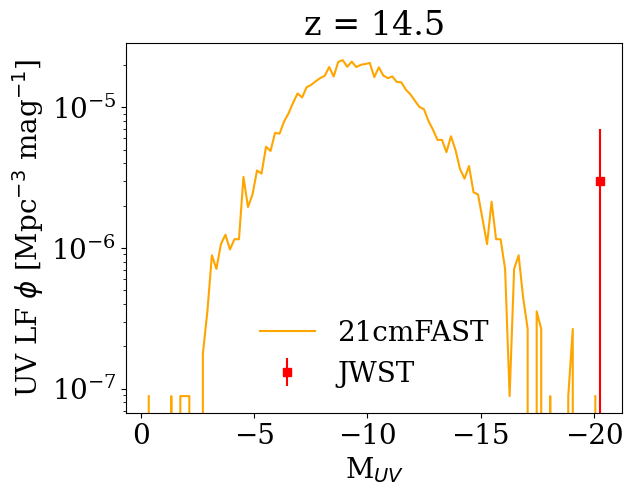

In [42]:
data_path = "/home/dbreitman/jeanzay/21CMMC_old/src/py21cmmc/data/"
for redshift in uvlf_redshifts:
    try:
        if redshift <= 11.:
            zstr = str(int(redshift))
        else:
            zstr = str(int(np.floor(redshift))) + "pt5"
        Donnan_Muv = np.load(data_path+"Donnan24_LF_lfuncs_z"+zstr+".npz", allow_pickle=True)["Muv"]
        Donnan_LF = np.load(data_path+"Donnan24_LF_lfuncs_z"+zstr+".npz", allow_pickle=True)["lfunc"]
        Donnan_sigma = np.load(data_path+"Donnan24_LF_sigmas_z"+zstr+".npz", allow_pickle=True)["sigma"]
    except:
        Donnan_Muv = Donnan_LF = Donnan_sigma = None
        
    try:
        zstr = str(int(redshift))
        Bouwens_Muv = np.load(data_path+"LF_lfuncs_z"+zstr+".npz", allow_pickle=True)["Muv"]
        Bouwens_LF = np.load(data_path+"LF_lfuncs_z"+zstr+".npz", allow_pickle=True)["lfunc"]
        Bouwens_sigma = np.load(data_path+"LF_sigmas_z"+zstr+".npz", allow_pickle=True)["sigma"]
    except:
        Bouwens_Muv = Bouwens_LF = Bouwens_sigma = None
    
    if Bouwens_Muv is not None:
        plt.errorbar(Bouwens_Muv, Bouwens_LF, yerr = Bouwens_sigma, color = "k", label = "HST", ls = "none", marker = "s")
    if Donnan_Muv is not None:
        plt.errorbar(Donnan_Muv, Donnan_LF, yerr = Donnan_sigma, color = "r", label = "JWST", ls = "none", marker = "s")
    plt.plot(uvlfs[str(redshift)]["M_uv"], uvlfs[str(redshift)]["lfunc"], color = "orange", label = "21cmFAST")
    plt.xlabel(r"M$_{UV}$")
    plt.ylabel(r"UV LF $\phi$ [Mpc$^{-3}$ mag$^{-1}$]")
    ax = plt.gca()
    ax.xaxis.set_inverted(True)
    plt.yscale("log")
    plt.legend(frameon=False)
    plt.title("z = " + str(redshift))
    plt.show()
    

In [43]:
lightcone = p21c.LightCone.from_file("/home/dbreitman/EOS25/TEST_F_ESC_-0pt1_ALPHA_ESC_0pt1_L384_HIIDIM256_DIM768/test_lc")

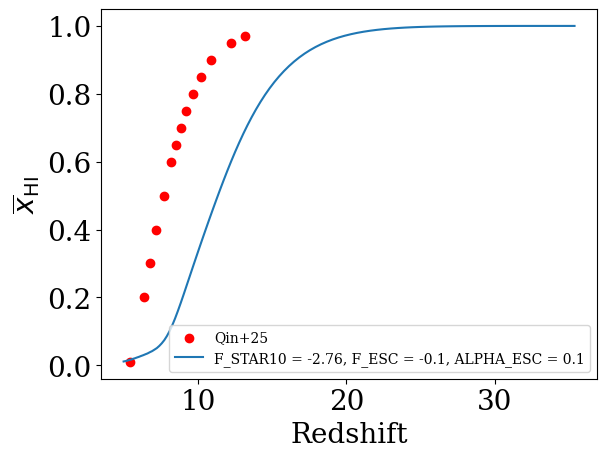

In [48]:
Qin25_z = [5.44, 6.35, 6.75, 7.17, 7.7, 8.2, 8.5, 8.85, 9.18, 9.65, 10.19, 10.9, 12.22, 13.17]
Qin25_xHI = [0.01, 0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.97]
plt.scatter(Qin25_z, Qin25_xHI, color = "r", label = "Qin+25")
plt.plot(lightcone.inputs.node_redshifts, lightcone.global_quantities["neutral_fraction"], label = "F_STAR10 = -2.76, F_ESC = -0.1, ALPHA_ESC = 0.1")
plt.xlabel("Redshift")
plt.ylabel(r"$\overline{x}_{\rm HI}$")
plt.legend(fontsize = 10)
plt.show()